In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!nvidia-smi

Fri Apr 22 18:09:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
USE_GPU = 1

In [4]:
# Import TensorFlow 
import tensorflow as tf

# Print the installed TensorFlow version
print(f'TensorFlow version: {tf.__version__}\n')

# Get all GPU devices on this server
gpu_devices = tf.config.list_physical_devices('GPU')

# Print the name and the type of all GPU devices
print('Available GPU Devices:')
for gpu in gpu_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set only the GPU specified as USE_GPU to be visible
# tf.config.set_visible_devices(gpu_devices[USE_GPU], 'GPU')

# Get all visible GPU  devices on this server
visible_devices = tf.config.get_visible_devices('GPU')

# Print the name and the type of all visible GPU devices
print('\nVisible GPU Devices:')
for gpu in visible_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set the visible device(s) to not allocate all available memory at once,
# but rather let the memory grow whenever needed
for gpu in visible_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.8.0

Available GPU Devices:
  /physical_device:GPU:0 GPU

Visible GPU Devices:
  /physical_device:GPU:0 GPU


In [5]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
os.chdir("drive/MyDrive/Challenge_dataset/")

In [8]:
with open("train.npy", "rb") as f:
  X = np.load(f)
  y = np.load(f)
  

# Normalize pixel values to be between 0 and 1
X = X / 255.0

In [10]:
class_names = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings',
               'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse',
               'harbor', 'intersection', 'mediumresidential', 'mobilehomepark',
               'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential',
               'storagetanks', 'tenniscourt']

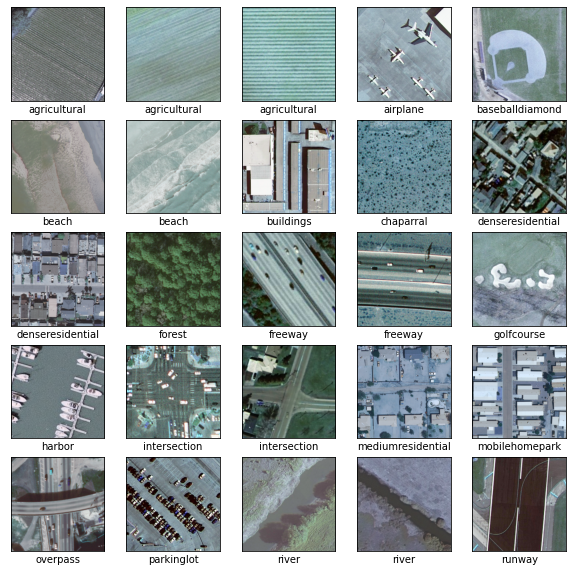

In [11]:
plt.figure(figsize=(10,10))
for i in range(0, 25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i*40])
    plt.xlabel(class_names[y[i*40]])
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(860, 256, 256, 3) (860,)
(216, 256, 256, 3) (216,)


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, ReLU, GlobalAveragePooling2D, Input

In [15]:
# Instantiate the ResNet50 model
conv_base =tf.keras.applications.resnet.ResNet50(input_shape=(256, 256, 3),
                          include_top=False,
                          weights='imagenet')

# freeze the layers
for layer in conv_base.layers:
  layer.trainable = False

names = []
for layer in conv_base.layers:
  names.append(layer.name)

names[-1] # getting the name of the last conv layer

last_layer = conv_base.get_layer('conv5_block3_out')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

inputs = Input(shape = (256, 256, 3))
x = conv_base(inputs)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a final softmax layer for classification
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, output)

94781440/94765736 [==============================] - 1s 0us/step
last layer output shape:  (None, 8, 8, 2048)


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 21)                10773     
                                                             

In [17]:
from tensorflow.keras.optimizers import RMSprop

# compile the model
model.compile(optimizer=RMSprop(lr=0.001),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [18]:
history = model.fit(x = X_train,
            y = y_train.reshape(860,1),
            validation_data=(X_test, y_test.reshape(216,1)),
            epochs=100)

Epoch 1/100


KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [ ]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')